In [168]:
import sys
import os
import os.path
# Import folder where folders pfaff and ramisch are saved to import respective functions
sys.path.append("/home/lisa/Documents/11-python")
import numpy as np
#scipy for equations and curves
from scipy.signal import find_peaks
from scipy.signal import correlate
from scipy.special import jv
from scipy.interpolate import interp1d 
from scipy.optimize import curve_fit
#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.ticker import MultipleLocator
#import pfaff to view PLIF data
from pfaff.readimg import sbf,plifimg,lvsor
from pfaff.readlvfile2 import readlvfile2
from pfaff.readlvfile2 import readlvfile2dict as rlv
from pfaff.readlvfile2 import calibMS
from pfaff.catashow import catashow
from camview.readlvfile3 import lvSummary
from lmfit.models import QuadraticModel
from lmfit import Model 
from lmfit.models import LinearModel

from ramisch.readspec import lvpmi
from lmfit import minimize, Parameters
import pandas as pd
rcParams.update({'font.size': 12})
rcParams.update({'font.serif': 'Arial'})

In [169]:
def FunctionFit(model, params, ydata, xdata ):
    function_fits = []
    for i in range(ydata.shape[0]):	
        result = model.fit(ydata[i,:], params, x=xdata)
        function_fits.append(result)
    return function_fits
#Custom Functions
# https://lmfit.github.io/lmfit-py/model.html#model-class-methods
def besselj0(x,amp0, nu00):
    y =amp0*np.abs(jv(0,np.pi/nu00*x))
    return y
def besselj2(x,f1,f2,nu02,OFF):
    # x is the wavenumber nu
    # amp is a scaling factor of the amplitude
    # phi 0 is just pi/nu0
	y  = (f1*(x/nu02)+f2*(x**2/nu02))*np.abs(jv(2,(np.pi/nu02)*x)) + OFF
	return y

# Introduction
## Data File Format
\begin{aligned}
& \text {Table 1.1. File Formats for measurement X}\\
&\begin{array}{cc}
\hline \hline \text {Techniques} & \text { File Format} \\
\hline \text {Time} & \text {realX.txt} \\
\text {Temperature thermocouple} & \text {realX.txt} \\
\text {Mass Spec} & \text {realX.txt} \\
\text {Flows} & \text {realX.txt}\\
\text {Temperatures} & \text {realX.txt}\\
\text {PM-IRRAS} & \text {realX.pmi}\\
\hline
\end{array}
\end{aligned}
The PMI data file is a custom made file format to acquire opus spectra in LABVIEW and synchronize it with other measurements saved in a separate text file such as temperature, pressure, flows and 
## Sample
AgCrPt (90:5:5), sputtered, annealed

# CO adsorption/desorption measurement


Define the folder where the different data sets are placed:

In [170]:
main = 'Example_Data/'
date = '2022-06-28'
foldername = main+'/'+date+'_'
if not os.path.isdir(main+date):
    print('Directory not found.')
    sys.exit()

Directory not found.


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


List the data files that we want to analyze:

In [15]:
files = {34: 'a',
         35: 'b',
         36:'c',
         37:'d',
         38:'e',
         39:'f',
         40: 'g',}

In [16]:
lvFiles = [foldername + 'real'+str(i)+'.txt' for i in files.keys()]
pmiFiles = [foldername + 'real'+str(i)+'.pmi' for i in files.keys()]

Summary of all data files:

In [42]:
lvSummary(lvFiles, coconc = 0.05, kelvin=False)

/usr/local/lib/python3.10/dist-packages/camview/readlvfile3.py:132: RuntimeWarning: invalid value encountered in double_scalars
  o2Partial=np.round(lvData['flows'][0][o2flow]/totalFlow*totalPressure,2)
/usr/local/lib/python3.10/dist-packages/camview/readlvfile3.py:133: RuntimeWarning: invalid value encountered in double_scalars
  coPartial=np.round(lvData['flows'][0][coflow]*coconc/totalFlow*totalPressure,2)


Filename,Start time,Temperature Range,Current Range,Pressure,O2 Partial,CO Partial,O2:CO Ratio
Example_Data//2022-06-28_real34.txt,2022-06-28 10:19:28.104,54.9 °C - 318.1 °C,1.0 mA - 999.0 mA,150.385 mbar,0.0 mbar,7.52 mbar,0.0:1
Example_Data//2022-06-28_real35.txt,2022-06-28 10:32:27.105,50.7 °C - 51.0 °C,0.0 mA - 1.0 mA,13.26 mbar,nan mbar,nan mbar,nan:1
Example_Data//2022-06-28_real36.txt,2022-06-28 10:55:53.104,46.8 °C - 47.0 °C,1.0 mA - 12.0 mA,62.515 mbar,0.0 mbar,3.14 mbar,0.0:1
Example_Data//2022-06-28_real37.txt,2022-06-28 10:56:09.354,46.9 °C - 47.1 °C,49.0 mA - 52.0 mA,63.155 mbar,0.0 mbar,3.15 mbar,0.0:1
Example_Data//2022-06-28_real38.txt,2022-06-28 10:57:53.354,46.3 °C - 332.4 °C,1.0 mA - 999.0 mA,63.16 mbar,0.0 mbar,3.16 mbar,0.0:1
Example_Data//2022-06-28_real39.txt,2022-06-28 11:16:39.946,45.1 °C - 45.6 °C,38.0 mA - 89.0 mA,63.295 mbar,0.0 mbar,3.16 mbar,0.0:1
Example_Data//2022-06-28_real40.txt,2022-06-28 11:18:11.354,43.4 °C - 331.0 °C,0.0 mA - 999.0 mA,63.295 mbar,0.0 mbar,3.16 mbar,0.0:1


## Real34

### Plot LabView & MS data:

In [36]:
file='real34'
date='2022-06-28'
newpath = main+r'Analysis/'
newpath += date + "_" +file #"separate"
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [117]:
# Load the Labview file containing all metadata and MS data:
lvFile = readlvfile2(foldername+file+'.txt')
lvFiledict = rlv(foldername+file+'.txt')
# Get the starting time:
lvstarttime      = int(lvFile[0][0])*3600 + int(lvFile[0][1])*60 + int(lvFile[0][2]) + int(lvFile[0][3])*10**-3 #when the Lv file starts recording
# Get time, temp, flow, MS and sor data:
time, temp       = lvFile[2], lvFile[3]*1.3 + 26
flAr, flO2, flCO = lvFile[6][:,0],lvFile[6][:,1],  lvFile[6][:,2]
sor              = lvFile[10]
totFl            = np.sum(lvFiledict['flows'][0])
totPres          =(lvFiledict['pressures'][0][1]+lvFiledict['pressures'][0][3]*1000)/2
coconc = 0.05
o2Partial        = np.round(flO2/totFl*totPres,2)
coPartial        = np.round(flCO*coconc/totFl*totPres,2)

In [118]:
msAr = calibMS(lvFile[7][:,4]/lvFile[7][:,4], lvFile[7][:,2]/lvFile[7][:,4], totFl, np.mean(flAr), totPres)
MSCO = calibMS(lvFile[7][:,2]/lvFile[7][:,4], lvFile[7][:,2]/lvFile[7][:,4], totFl, 5, totPres) #(I,IcalibGas, Flowtot, FlowcalibGas, Ptot)
msO2 = calibMS(lvFile[7][:,3]/lvFile[7][:,4], lvFile[7][:,2]/lvFile[7][:,4], totFl, np.mean(flO2), totPres)

In [119]:
MSCO

array([5.30266274, 5.30266274, 5.52226361, ..., 4.86796631, 5.59717584,
       5.34962458])

In [89]:
time2temp = interp1d(time, temp)

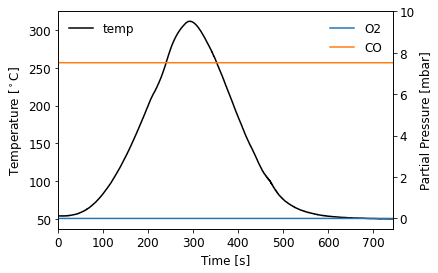

In [136]:
plt.figure()
ax=plt.gca()
ax1 = ax.twinx()
ax.plot(time, temp, color='black',label='temp')
ax1.plot(time, o2Partial, label='O2')
ax1.plot(time, coPartial, label='CO')
ax.set_ylabel('Temperature [$^\circ$C]')
ax.set_xlabel('Time [s]')
ax1.set_ylabel('Partial Pressure [mbar]')
ax1.set_ylim([-0.5,10])
ax1.set_xlim([0,np.max(time)])
ax.legend(loc='upper left',frameon=False)
ax1.legend(frameon=False)

### PM-IRRAS

In [145]:
pmiFilename    = foldername+file+'.pmi'
#Load pmirras file
pmidata        = lvpmi(pmiFilename)
# Get header information
header         = pmidata._read_header(pmiFilename)
# Get spectra
stTime, R    = pmidata.getspecdata() # R as in reflectance, stTime= starting Time of PMI scans
NbrSpectra     = pmidata.getNbrSpectra()
# Get time stamp of spectra
starttime      = header[0][0]*3600 + header[0][1]*60 + header[0][2] + header[0][3]/1000 #when the Lv file starts recording
time_pmi       = [stTime[i][0]*3600 + stTime[i][1]*60 + stTime[i][2] + stTime[i][3]/1000 for i in range(NbrSpectra)] - starttime
meas_time      = np.mean(np.diff(time_pmi))
time_pmi       = meas_time + time_pmi
print(time_pmi)

File contains: 11 Spectra.
File contains: 11 Spectra.
[-10.2995  56.2135 122.7305 189.2465 255.7635 322.2825 388.8025 457.0295
 523.5495 590.0725 656.5955]


Raw data: 
Plot raw data

Text(0, 0.5, 'Amplitude')

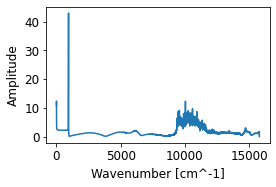

In [147]:
nu = np.linspace(15796.612559,pmidata.endNbr,pmidata.Pts) # define the wavenumber x-axis
plt.figure(figsize=(4,2.5))
plt.plot(nu,np.mean(R,axis=0))
plt.xlabel('Wavenumber [cm^-1]')
plt.ylabel('Amplitude')

Cut raw data

[3500, 1800]
6377 7258
File contains: 11 Spectra.


Text(0, 0.5, 'Amplitude')

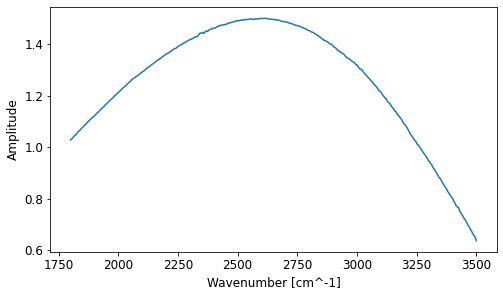

In [149]:
rangeCut = [3500,1800]
nu_cut,R_cut = pmidata.getRegion(rangeCut)

plt.figure(figsize=(8,4.5))
#plt.plot(nu_cut,np.mean(R_cut,axis=0))
plt.plot(nu_cut,R_cut[6,:])

plt.xlabel('Wavenumber [cm^-1]')
plt.ylabel('Amplitude')

Fit Bessel  background

In [150]:
bmodel = Model(besselj2)
paramsBes2 = bmodel.make_params()
paramsBes2['f1'].set(value=3.0, min=2.0, max=4)
paramsBes2['f2'].set(value=7.5e-5, min=-1, max=1)

paramsBes2['nu02'].set(value=2340, min=2300,max=2400)
paramsBes2['OFF'].set(value=0.1, min=0, max=0.2)

In [151]:
result_fits = FunctionFit(bmodel, paramsBes2, R_cut,nu_cut)

In [152]:
result_fits[10].params

name,value,standard error,relative error,initial value,min,max,vary
f1,2.00000000,0.00221324,(0.11%),3.0,2.00000000,4.00000000,True
f2,6.5036e-05,5.6540e-06,(8.69%),7.5e-05,-1.00000000,1.00000000,True
nu02,2310.92694,1.41303212,(0.06%),2340,2300.00000,2400.00000,True
OFF,0.11235183,0.00311079,(2.77%),0.1,0.00000000,0.20000000,True


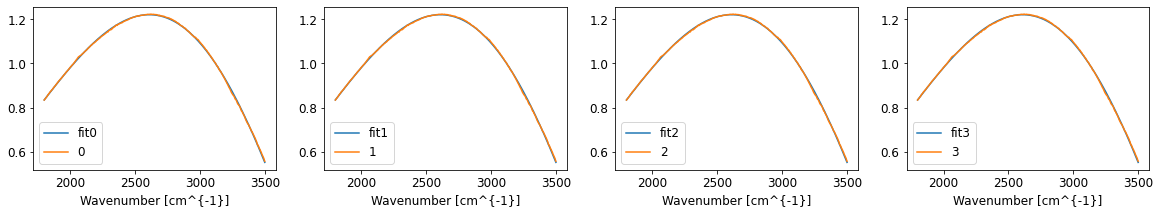

In [167]:
fig, axs = plt.subplots(1,4,figsize=(20,3))
for ax in range(4):
    axs[ax].plot(nu_cut, result_fits[i].best_fit, label='fit'+str(ax))
    axs[ax].plot(nu_cut, R_cut[i,:], label=str(ax))
    axs[ax].legend()
    axs[ax].set_xlabel('Wavenumber [cm^{-1}]')
plt.subplots_adjust(hspace=0)
plt.savefig(newpath+'/'+file+'_BG_fit.png',dpi=300)

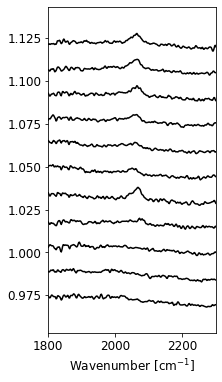

In [166]:

R_corr = []
for i in range(R_cut.shape[0]):
    R_corr.append(R_cut[i,:]/result_fits[i].best_fit)
#############################################################
plt.figure(figsize=(3,6))
offset = 0
for i in range(R_cut.shape[0]):
    plt.plot(nu_cut, R_corr[i]/np.max(R_corr) + offset, label=str(i), color='black')
    offset =offset+0.015
plt.xlim([1800,2300])
plt.xlabel('Wavenumber [cm$^{-1}$]')
#plt.ylim([0.995,1.01])
np.save(newpath+'/'+file+'_corrected_spectra.npy', R_corr)